In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/stanford-natural-language-inference-corpus/README.txt
/kaggle/input/stanford-natural-language-inference-corpus/snli_1.0_test.csv
/kaggle/input/stanford-natural-language-inference-corpus/snli_1.0_train.csv
/kaggle/input/stanford-natural-language-inference-corpus/snli_1.0_dev.csv


In [2]:
snli_train = pd.read_csv('/kaggle/input/stanford-natural-language-inference-corpus/snli_1.0_train.csv',nrows=300000)
snli_test = pd.read_csv('/kaggle/input/stanford-natural-language-inference-corpus/snli_1.0_test.csv')

In [3]:
print(snli_train['sentence1'][0],snli_train['sentence2'][0], snli_train['gold_label'][0])
print(snli_train['sentence1'][1],snli_train['sentence2'][1], snli_train['gold_label'][1])
print(snli_train['sentence1'][2],snli_train['sentence2'][2], snli_train['gold_label'][2])

A person on a horse jumps over a broken down airplane. A person is training his horse for a competition. neutral
A person on a horse jumps over a broken down airplane. A person is at a diner, ordering an omelette. contradiction
A person on a horse jumps over a broken down airplane. A person is outdoors, on a horse. entailment


In [4]:
# Filter and rename the important columns
train_df = snli_train.filter(['sentence1','sentence2','gold_label'], axis=1)
test_df = snli_test.filter(['sentence1','sentence2','gold_label'], axis=1)
train_df = train_df.rename(columns={"sentence1": "premise", "sentence2": "hypothesis"})
test_df = test_df.rename(columns={"sentence1": "premise", "sentence2": "hypothesis"})

# exclude sentences which could not be categorised
train_df = train_df[train_df['gold_label'] != "-"]
test_df = test_df[test_df['gold_label'] != "-"]

train_df['gold_label'].value_counts()

entailment       100064
contradiction     99903
neutral           99652
Name: gold_label, dtype: int64

In [5]:
import tensorflow as tf
import transformers

max_length = 128  # Maximum length of input sentence to the model.
batch_size = 256
epochs = 40

In [6]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.is_available()

True

In [7]:
train_df["label"] = train_df["gold_label"].apply(
    lambda x: 0 if x == "contradiction" else 1 if x == "entailment" else 2
)
y_train = tf.keras.utils.to_categorical(train_df.label, num_classes=3)

In [8]:
tokenizer = transformers.DistilBertTokenizer.from_pretrained("distilbert-base-uncased", do_lower_case=True)

In [9]:
sentence_pairs = train_df[['premise', 'hypothesis']].values.astype('str')

In [10]:
encoded = tokenizer.batch_encode_plus(
    sentence_pairs.tolist(),
    add_special_tokens=True,
    max_length=max_length,
    return_attention_mask=True,
    return_token_type_ids=True,
    pad_to_max_length=True,
    return_tensors="tf")

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/opt/conda/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2022: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [11]:
input_ids = np.array(encoded["input_ids"], dtype="int32")
attention_masks = np.array(encoded["attention_mask"], dtype="int32")
token_type_ids = np.array(encoded["token_type_ids"], dtype="int32")

In [12]:
import keras
from keras import datasets, layers, models

def create_bert_model():
    # Encoded token ids from BERT tokenizer.
    input_ids = layers.Input(shape=(max_length,), dtype=tf.int32, name="input_ids")
    # Attention masks indicates to the model which tokens should be attended to.
    attention_masks = layers.Input(shape=(max_length,), dtype=tf.int32, name="attention_masks")
    # Token type ids are binary masks identifying different sequences in the model.
#     token_type_ids = layers.Input(shape=(max_length,), dtype=tf.int32, name="token_type_ids")
    
    bert_model = transformers.TFDistilBertModel.from_pretrained('distilbert-base-uncased', return_dict=False)
    bert_model.trainable = False

    sequence_output = bert_model(input_ids, attention_mask=attention_masks)
    
    y_1= layers.Dense(100,activation='tanh')(sequence_output[0])
    y_2= layers.Dense(100,activation='tanh')(y_1)
    y_3= layers.Dense(100,activation='tanh')(y_2)

    output=layers.Flatten()(y_3)
    output = layers.Dense(3, activation='softmax')(output)

    model = keras.models.Model([input_ids, attention_masks], output)
    model.summary()
    return model
model = create_bert_model()

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['vocab_transform', 'vocab_layer_norm', 'activation_13', 'vocab_projector']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 128)]        0                                            
__________________________________________________________________________________________________
attention_masks (InputLayer)    [(None, 128)]        0                                            
__________________________________________________________________________________________________
tf_distil_bert_model (TFDistilB ((None, 128, 768),)  66362880    input_ids[0][0]                  
                                                                 attention_masks[0][0]            
__________________________________________________________________________________________________
dense (Dense)                   (None, 128, 100)     76900       tf_distil_bert_model[0

In [13]:
model.compile(optimizer='Adadelta',loss='categorical_crossentropy',metrics = ['accuracy'])
history = model.fit([input_ids, attention_masks],
                    y_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_split=0.2,
                    verbose=1,
                    use_multiprocessing=True,
                    workers=-1)

Epoch 1/40
937/937 [==============================] - 660s 705ms/step - loss: 1.1059 - accuracy: 0.3587 - val_loss: 1.0887 - val_accuracy: 0.3912
Epoch 2/40
937/937 [==============================] - 660s 704ms/step - loss: 1.0808 - accuracy: 0.4036 - val_loss: 1.0667 - val_accuracy: 0.4309
Epoch 3/40
937/937 [==============================] - 658s 702ms/step - loss: 1.0621 - accuracy: 0.4338 - val_loss: 1.0493 - val_accuracy: 0.4538
Epoch 4/40
937/937 [==============================] - 658s 703ms/step - loss: 1.0461 - accuracy: 0.4560 - val_loss: 1.0352 - val_accuracy: 0.4699
Epoch 5/40
937/937 [==============================] - 658s 702ms/step - loss: 1.0345 - accuracy: 0.4688 - val_loss: 1.0241 - val_accuracy: 0.4818
Epoch 6/40
937/937 [==============================] - 659s 703ms/step - loss: 1.0249 - accuracy: 0.4797 - val_loss: 1.0146 - val_accuracy: 0.4922
Epoch 7/40
937/937 [==============================] - 663s 707ms/step - loss: 1.0164 - accuracy: 0.4899 - val_loss: 1.0060 -

In [14]:
#!pip install -q pyyaml h5py
import h5py
model.save_weights('bert_weights_300000_40epochs.hdf5')


In [15]:
sentence_pairs_test = test_df[['premise', 'hypothesis']].values.astype('str')


encoded_test = tokenizer.batch_encode_plus(
    sentence_pairs_test.tolist(),
    add_special_tokens=True,
    max_length=max_length,
    return_attention_mask=True,
    return_token_type_ids=True,
    pad_to_max_length=True,
    return_tensors="tf")

input_ids = np.array(encoded_test["input_ids"], dtype="int32")
attention_masks = np.array(encoded_test["attention_mask"], dtype="int32")
token_type_ids = np.array(encoded_test["token_type_ids"], dtype="int32")

test_pred = model.predict([input_ids, attention_masks], batch_size=batch_size)

test_results_bert = pd.DataFrame(test_pred)
test_results_bert.to_csv("Bert_test_results_300000_40epochs.csv")

In [16]:
pd.DataFrame.from_dict(history.history).to_csv('bert_history_300000_40epochs.csv',index=False)

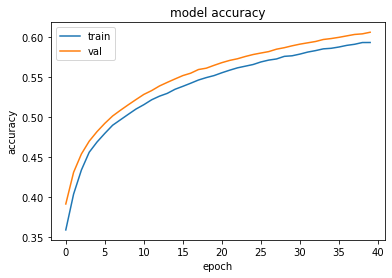

In [17]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
# plt.show()
plt.savefig('bert_accuracy_300000_40epochs.png')